In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jan  7 13:52:41 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os


# ResNet18을 위해 최대한 간단히 수정한 BasicBlock 클래스 정의
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        self.shortcut = nn.Sequential() # identity인 경우
        if stride != 1: # stride가 1이 아니라면, Identity mapping이 아닌 경우
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# ResNet18 함수 정의
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# 각 데이터셋 크기 확인
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

# CIFAR-10 클래스 이름 확인
classes = train_dataset.classes
print(f"Classes in CIFAR-10: {classes}")

# 각 클래스별 샘플 수 확인
from collections import Counter

train_class_counts = Counter([train_dataset.targets[i] for i in range(len(train_dataset))])
test_class_counts = Counter([test_dataset.targets[i] for i in range(len(test_dataset))])

print("\nClass distribution in training dataset:")
for class_idx, count in train_class_counts.items():
    print(f"Class '{classes[class_idx]}': {count} samples")

print("\nClass distribution in testing dataset:")
for class_idx, count in test_class_counts.items():
    print(f"Class '{classes[class_idx]}': {count} samples")

Number of training samples: 50000
Number of testing samples: 10000
Classes in CIFAR-10: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Class distribution in training dataset:
Class 'frog': 5000 samples
Class 'truck': 5000 samples
Class 'deer': 5000 samples
Class 'automobile': 5000 samples
Class 'bird': 5000 samples
Class 'horse': 5000 samples
Class 'ship': 5000 samples
Class 'cat': 5000 samples
Class 'dog': 5000 samples
Class 'airplane': 5000 samples

Class distribution in testing dataset:
Class 'cat': 1000 samples
Class 'ship': 1000 samples
Class 'airplane': 1000 samples
Class 'frog': 1000 samples
Class 'automobile': 1000 samples
Class 'truck': 1000 samples
Class 'dog': 1000 samples
Class 'horse': 1000 samples
Class 'deer': 1000 samples
Class 'bird': 1000 samples


In [ ]:
device = 'cuda'

net = ResNet18()
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

learning_rate = 0.1
file_name = 'resnet18_cifar10.pt'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)


def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current benign train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Current benign train loss:', loss.item())

    print('\nTotal benign train accuarcy:', 100. * correct / total)
    print('Total benign train loss:', train_loss)


def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', loss / total)

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')


def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:

# for epoch in range(0, 200):
for epoch in range(0, 20):
    adjust_learning_rate(optimizer, epoch)
    train(epoch)
    test(epoch)



[ Train epoch: 0 ]

Current batch: 0
Current benign train accuracy: 0.1484375
Current benign train loss: 2.381592273712158

Current batch: 100
Current benign train accuracy: 0.234375
Current benign train loss: 1.8936506509780884

Current batch: 200
Current benign train accuracy: 0.3515625
Current benign train loss: 1.752280831336975

Current batch: 300
Current benign train accuracy: 0.3671875
Current benign train loss: 1.6877548694610596

Total benign train accuarcy: 31.888
Total benign train loss: 742.3491257429123

[ Test epoch: 0 ]

Test accuarcy: 41.31
Test average loss: 0.015851962685585023
Model Saved!

[ Train epoch: 1 ]

Current batch: 0
Current benign train accuracy: 0.4609375
Current benign train loss: 1.4302563667297363

Current batch: 100
Current benign train accuracy: 0.46875
Current benign train loss: 1.4448623657226562

Current batch: 200
Current benign train accuracy: 0.421875
Current benign train loss: 1.5256506204605103

Current batch: 300
Current benign train accura

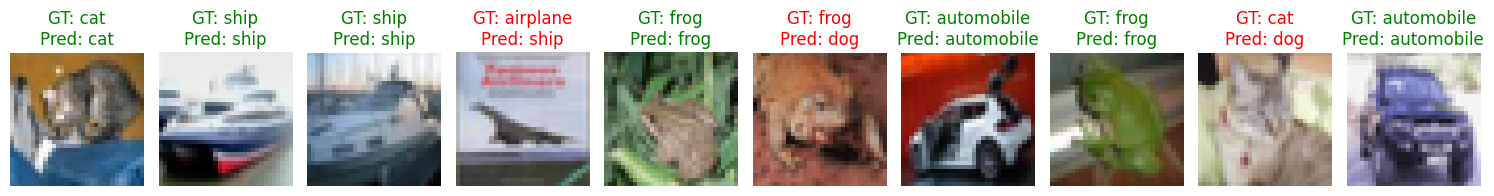

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# CIFAR-10 카테고리 이름
CIFAR10_CLASSES = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# 10개의 샘플을 확인하는 함수 정의
def visualize_predictions_with_labels(data_loader, model, device, num_samples=10):
    model.eval()
    images, labels, predictions = [], [], []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)

            for i in range(inputs.size(0)):
                if len(images) < num_samples:
                    images.append(inputs[i].cpu())
                    labels.append(targets[i].cpu().item())
                    predictions.append(preds[i].cpu().item())
                else:
                    break

            if len(images) >= num_samples:
                break

    # 이미지를 시각화
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for idx, ax in enumerate(axes):
        img = images[idx].permute(1, 2, 0).numpy()  # 이미지 차원 변경 (C, H, W -> H, W, C)
        img = (img * 255).astype(np.uint8)  # 정규화 해제 (0-1 -> 0-255)
        ax.imshow(img)
        ax.axis('off')

        # 카테고리 이름을 사용하여 제목 작성
        gt_label = CIFAR10_CLASSES[labels[idx]]
        pred_label = CIFAR10_CLASSES[predictions[idx]]
        title = f"GT: {gt_label}\nPred: {pred_label}"

        # 정답 여부에 따라 제목 색상 변경
        if labels[idx] == predictions[idx]:
            ax.set_title(title, color='green')  # 정답
        else:
            ax.set_title(title, color='red')  # 오답

    plt.tight_layout()
    plt.show()

# 샘플 확인 실행
visualize_predictions_with_labels(test_loader, net, device, num_samples=10)

VGGNet16

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# VGGNet 클래스 정의
class VGGNet(nn.Module):
    def __init__(self, architecture, num_classes=10):
        super(VGGNet, self).__init__()
        self.features = self._make_layers(architecture)
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)  # Flatten the feature map
        out = self.classifier(out)
        return out

    def _make_layers(self, architecture):
        layers = []
        in_channels = 3  # 입력 이미지 채널 수 (RGB이므로 3)
        for x in architecture:
            if x == 'M':  # MaxPooling layer
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:  # Convolutional layer
                layers += [
                    nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                    nn.BatchNorm2d(x),  # 배치 정규화 추가 가능
                    nn.ReLU(inplace=True)
                ]
                in_channels = x
        return nn.Sequential(*layers)


# VGGNet 아키텍처 구성
# VGG16 아키텍처 예제: 컨볼루션 채널 수와 MaxPooling 표시
VGG16_architecture = [
    64, 64, 'M',
    128, 128, 'M',
    256, 256, 256, 'M',
    512, 512, 512, 'M',
    512, 512, 512, 'M'
]

# VGG16 함수 정의
def VGG16():
    return VGGNet(VGG16_architecture)

In [ ]:
device = 'cuda'

# VGG16 모델 사용
net = VGG16()
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

learning_rate = 0.1
file_name = 'vgg16_cifar10.pt'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)

def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)  # VGG16 모델에서의 forward pass
        loss = criterion(outputs, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current benign train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Current benign train loss:', loss.item())

    print('\nTotal benign train accuracy:', 100. * correct / total)
    print('Total benign train loss:', train_loss)


def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    print('\nTest accuracy:', 100. * correct / total)
    print('Test average loss:', loss / total)

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')


def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:

# for epoch in range(0, 200):
for epoch in range(0, 20):
    adjust_learning_rate(optimizer, epoch)
    train(epoch)
    test(epoch)



[ Train epoch: 0 ]

Current batch: 0
Current benign train accuracy: 0.1171875
Current benign train loss: 2.347382068634033

Current batch: 100
Current benign train accuracy: 0.1875
Current benign train loss: 2.1332879066467285

Current batch: 200
Current benign train accuracy: 0.203125
Current benign train loss: 2.026221513748169

Current batch: 300
Current benign train accuracy: 0.2421875
Current benign train loss: 1.9787973165512085

Total benign train accuracy: 18.768
Total benign train loss: 808.154373884201

[ Test epoch: 0 ]

Test accuracy: 20.58
Test average loss: 0.02019383615255356
Model Saved!

[ Train epoch: 1 ]

Current batch: 0
Current benign train accuracy: 0.2109375
Current benign train loss: 1.871276617050171

Current batch: 100
Current benign train accuracy: 0.296875
Current benign train loss: 1.86435866355896

Current batch: 200
Current benign train accuracy: 0.375
Current benign train loss: 1.891772985458374

Current batch: 300
Current benign train accuracy: 0.39062

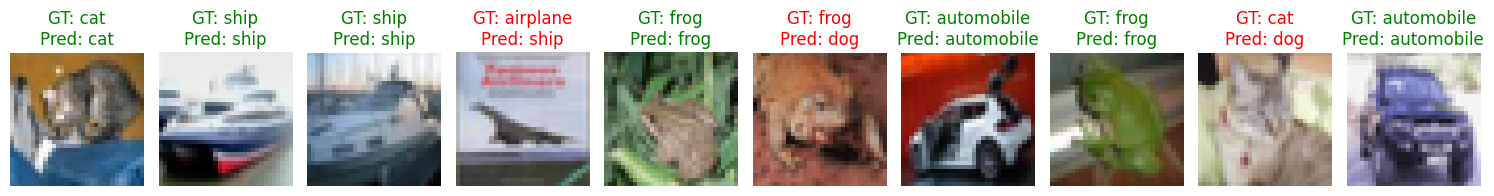

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# CIFAR-10 카테고리 이름
CIFAR10_CLASSES = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# 10개의 샘플을 확인하는 함수 정의
def visualize_predictions_with_labels(data_loader, model, device, num_samples=10):
    model.eval()
    images, labels, predictions = [], [], []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)

            for i in range(inputs.size(0)):
                if len(images) < num_samples:
                    images.append(inputs[i].cpu())
                    labels.append(targets[i].cpu().item())
                    predictions.append(preds[i].cpu().item())
                else:
                    break

            if len(images) >= num_samples:
                break

    # 이미지를 시각화
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for idx, ax in enumerate(axes):
        img = images[idx].permute(1, 2, 0).numpy()  # 이미지 차원 변경 (C, H, W -> H, W, C)
        img = (img * 255).astype(np.uint8)  # 정규화 해제 (0-1 -> 0-255)
        ax.imshow(img)
        ax.axis('off')

        # 카테고리 이름을 사용하여 제목 작성
        gt_label = CIFAR10_CLASSES[labels[idx]]
        pred_label = CIFAR10_CLASSES[predictions[idx]]
        title = f"GT: {gt_label}\nPred: {pred_label}"

        # 정답 여부에 따라 제목 색상 변경
        if labels[idx] == predictions[idx]:
            ax.set_title(title, color='green')  # 정답
        else:
            ax.set_title(title, color='red')  # 오답

    plt.tight_layout()
    plt.show()

# 샘플 확인 실행
visualize_predictions_with_labels(test_loader, net, device, num_samples=10)